In [1]:
import h5py
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import math

# Ingest data

In [ ]:
%%time

with h5py.File('./data/data.h5', 'r') as f:
    train = f['train'][:]#.astype(np.float32)
    trainIds = f['train_ids'][:]
    
# The current dype is uint8. Need to change dtype.
train = train.astype(np.float32)

# Change channel position to make it easier for pre-trained model.
train = np.moveaxis(train, 1,3)
print('Training set shape: ',train.shape)

# Normalize image arrays

In [ ]:
%%time

train = np.divide(train, 255)

# Make Y labels for the model

In [ ]:
### Get labels with organelle of interest
# 0: 'Nucleoplasm',  
# 1: 'Nuclear membrane',   
# 2: 'Nucleoli',   
# 3: 'Nucleoli fibrillar center',   
# 4: 'Nuclear speckles',   
# 5: 'Nuclear bodies',   
# 6: 'Endoplasmic reticulum',   
# 7: 'Golgi apparatus',   
# 8: 'Peroxisomes',   
# 9: 'Endosomes',   
# 10: 'Lysosomes',   
# 11: 'Intermediate filaments',   
# 12: 'Actin filaments',   
# 13: 'Focal adhesion sites',   
# 14: 'Microtubules',   
# 15: 'Microtubule ends',   
# 16: 'Cytokinetic bridge',   
# 17: 'Mitotic spindle',   
# 18: 'Microtubule organizing center',   
# 19: 'Centrosome',   
# 20: 'Lipid droplets',   
# 21: 'Plasma membrane',   
# 22: 'Cell junctions',   
# 23: 'Mitochondria',   
# 24: 'Aggresome',   
# 25: 'Cytosol',   
# 26: 'Cytoplasmic bodies',   
# 27: 'Rods & rings' 

targetId = 0

file_path = './data/train_labels.csv'
dfLabels = pd.read_csv(file_path)
dfLabels['Target'] = dfLabels['Target'].apply(lambda x: x.split())
idx = [i for i, x in enumerate(dfLabels['Target']) for organelle in x if organelle == str(targetId)]
print('Number of samples for targetId {}: {}'.format(targetId, len(idx)))

# Get image id's for for samples that have that organelle.
labelIds = dfLabels.iloc[idx,:]['Id']

# Convert to bytes for matching in the hdf5 label_ids array
labelIds = [str.encode(Id) for Id in labelIds]

# Fastest and most efficient way to getting matches of 2 lists.
# Take the index which will be used to find training examples with a label.
# https://stackoverflow.com/questions/29452735/find-the-indices-at-which-any-element-of-one-list-occurs-in-another
st = set(labelIds)
positiveLabel = [i for i, x in enumerate(trainIds) if x in st]

# Initizlize Y
Y = np.zeros((len(trainIds), 1))
# Fill positive label with positive index list
Y[positiveLabel,:] = 1

# Split Data: Train, Val, Test

In [ ]:
def train_val_test_split(Xdata, Ydata, train_size, val_size):
    '''Shuffle and split data into 3 sub-sets: train, validation, and test.
    
    Arguments:
    Xdata -- numpy array, training data. m must be (m, ...)
    Ydata -- numpy array, label data. m must be (m, ...)
    train_size -- float, split ratio. Ex. 0.8 for 80% for train data.
    val_size -- float, split ratio of desired amount. Ex. 0.2 for 20% for val data.
    
    Return:
    Xdata_train -- X train set
    Xdata_val -- X val set
    Xdata_test -- X test set
    
    Ydata_train -- Y train set
    Ydata_val -- Y val set
    Ydata_test -- Y test set
    '''
    
    assert Xdata.shape[0] == Ydata.shape[0], 'Train and Label examples are not equal.'
    
    shuff_id = np.random.permutation(train.shape[0])
    
    train_count = math.floor(Xdata.shape[0]*train_size)
    val_count = math.floor(Xdata.shape[0]*val_size)
    
    train_ix, val_ix, test_ix = np.split(shuff_id, [train_count, train_count+val_count])
    
    Xdata_train = Xdata[train_ix, ...]
    Xdata_val = Xdata[val_ix, ...]
    Xdata_test = Xdata[test_ix, ...]
        
    Ydata_train = Ydata[train_ix, ...]
    Ydata_val = Ydata[val_ix, ...]
    Ydata_test = Ydata[test_ix, ...]
        
    return Xdata_train, Xdata_val, Xdata_test, Ydata_train, Ydata_val, Ydata_test

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = train_val_test_split(train, Y, 0.7, 0.15)

In [ ]:
assert X_train.shape[0]+X_val.shape[0]+X_test.shape[0]==train.shape[0]

In [ ]:
del train, Y

In [ ]:
Image.fromarray(X_train[30,:,:,2]*255).convert('RGB')

In [2]:
############## Testing data read in

%%time
with h5py.File('./data/target0-norm-split.hdf5', 'r') as hf:
    X_train = hf['X_train'][:]
    X_val = hf['X_val'][:]
    X_test = hf['X_test'][:]
    
    Y_train = hf['Y_train'][:]
    Y_val = hf['Y_val'][:]
    Y_test = hf['Y_test'][:]




# with h5py.File('./data/data.h5', 'r') as f:
#     train = f['train'][:]#.astype(np.float32)
#     trainIds = f['train_ids'][:]

(21750, 224, 224, 4)
(4660, 224, 224, 4)
(4662, 224, 224, 4)
(21750, 1)
(4660, 1)
(4662, 1)


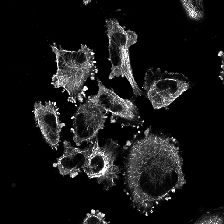

In [24]:
######################
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

Image.fromarray(X_train[3300,:,:,2]*255).convert('RGB')

# Create TensorFlow CNN model

In [ ]:
def create_placeholders():
    X = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 4], name='Input')
    Y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name = 'Labels')
    return X, Y

In [ ]:
testY = tf.placeholder(dtype=tf.float32, shape=[None, 1])
with tf.Session() as sess:
    print(sess.run(testY, feed_dict={testY: Y_val}))